In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from mcc import (
    Contract,
    ResolvableContract,
    EuropeanOption,
    Zero,
    One,
    Give,
    Scale,
    And,
    Or,
    Until,
    KonstFloat,
    Stock,
    Model,
    generate_simple_cashflows_in_numeraire_currency,
    evaluate,
)
from mcc.pricing_models import simulate_equity_black_scholes_model
from mcc.pricing_models.stochastic_processes import GeometricBrownianMotion

In [2]:
@dataclass
class EquityCall(ResolvableContract):
    maturity: np.datetime64
    stock: str
    strike: float
    currency: str

    def resolve(self) -> Contract:
        fw = Stock(self.stock) * One(self.currency) - self.strike * One(self.currency)
        return EuropeanOption(self.maturity, fw).resolve()

In [3]:
maturity = np.datetime64("2021-06-01")
stock = "ABC"
strike = 55
currency = "USD"

In [4]:
call = EquityCall(maturity, stock, strike, currency)
call

EquityCall(maturity=numpy.datetime64('2021-06-01'), stock='ABC', strike=55, currency='USD')

In [5]:
call.resolve()

When(observable=At(date=numpy.datetime64('2021-06-01')), contract=Or(contracts=[And(contracts=[Scale(observable=Stock(identifier='ABC'), contract=One(currency='USD')), Give(contract=Scale(observable=KonstFloat(constant=55), contract=One(currency='USD')))]), Zero()]))

In [6]:
call.resolve().resolve()

When(observable=At(date=numpy.datetime64('2021-06-01')), contract=Or(contracts=[And(contracts=[Scale(observable=Stock(identifier='ABC'), contract=One(currency='USD')), Give(contract=Scale(observable=KonstFloat(constant=55), contract=One(currency='USD')))]), Zero()]))

In [7]:
print(call)

When(2021-06-01, Or(And(Scale(Stock(ABC), One(USD)), Give(Scale(55, One(USD)))), Zero))


In [8]:
spot = 50
volatility = 0.2
dategrid = np.array(
    [
        np.datetime64("2021-01-01"),
        np.datetime64("2021-02-01"),
        np.datetime64("2021-03-01"),
        np.datetime64("2021-04-01"),
        np.datetime64("2021-05-01"),
        np.datetime64("2021-06-01"),
    ]
)
n = 100
rnd = np.random.RandomState(123)

(100, 6)

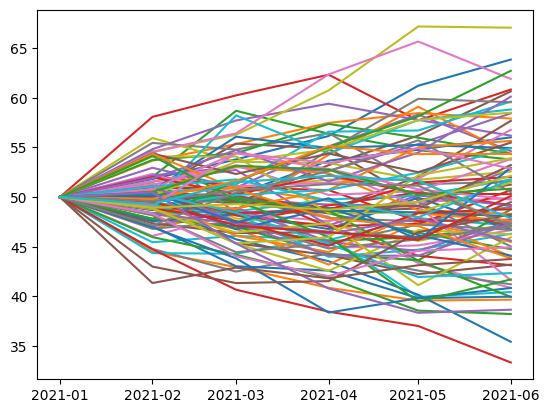

In [9]:
model = simulate_equity_black_scholes_model(
    "ABC", "USD", spot, dategrid, volatility, 0, n, rnd
)
plt.plot(model.dategrid, model.simulated_stocks["ABC"].T)
model.simulated_stocks["ABC"].shape

0.8273379954072637

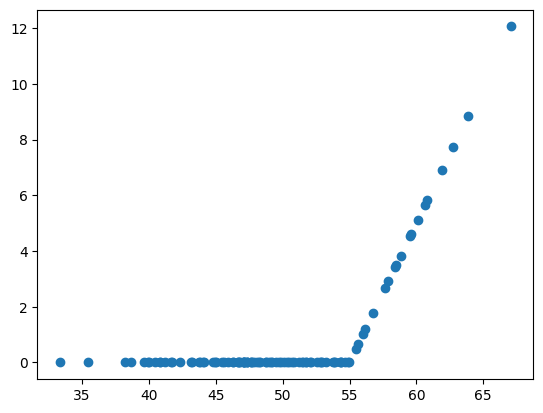

In [10]:
cf = generate_simple_cashflows_in_numeraire_currency(model, call.resolve())
plt.scatter(model.simulated_stocks["ABC"][:, -1], cf)
evaluate(model, call.resolve())

In [11]:
@dataclass
class EquityPut(ResolvableContract):
    maturity: np.datetime64
    stock: str
    strike: float
    currency: str

    def resolve(self) -> Contract:
        fw = self.strike * One(self.currency) - Stock(self.stock) * One(self.currency)
        return EuropeanOption(self.maturity, fw).resolve()

In [12]:
put = EquityPut(maturity, stock, strike, currency)
print(put)

When(2021-06-01, Or(And(Scale(55, One(USD)), Give(Scale(Stock(ABC), One(USD)))), Zero))


6.124665974546052

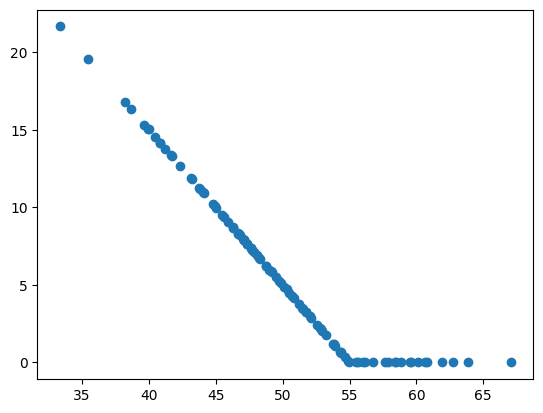

In [13]:
cf = generate_simple_cashflows_in_numeraire_currency(model, put.resolve())
plt.scatter(model.simulated_stocks["ABC"][:, -1], cf)
evaluate(model, put.resolve())

In [14]:
synthetic_forward = call.resolve() - put.resolve()
print(synthetic_forward)

And(When(2021-06-01, Or(And(Scale(Stock(ABC), One(USD)), Give(Scale(55, One(USD)))), Zero)), Give(When(2021-06-01, Or(And(Scale(55, One(USD)), Give(Scale(Stock(ABC), One(USD)))), Zero))))


-5.297327979138788

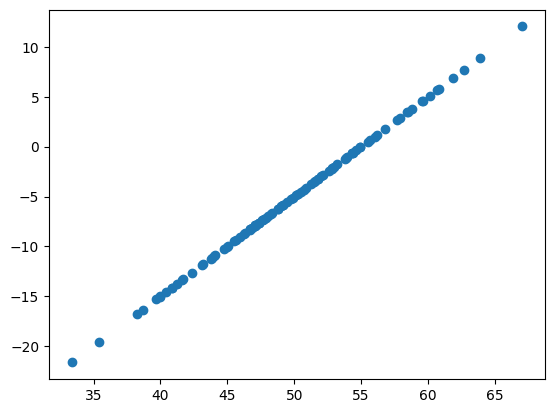

In [15]:
cf = generate_simple_cashflows_in_numeraire_currency(model, synthetic_forward)
plt.scatter(model.simulated_stocks["ABC"][:, -1], cf)
evaluate(model, synthetic_forward)

In [16]:
upper_knockout = Until(Stock("ABC") >= 63, call.resolve())
print(upper_knockout)

Until(Stock(ABC) >= 63, When(2021-06-01, Or(And(Scale(Stock(ABC), One(USD)), Give(Scale(55, One(USD)))), Zero)))


0.5493307691200464

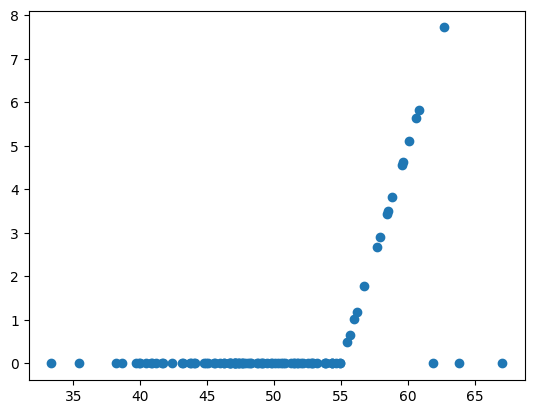

In [17]:
cf = generate_simple_cashflows_in_numeraire_currency(model, upper_knockout)
plt.scatter(model.simulated_stocks["ABC"][:, -1], cf)
evaluate(model, upper_knockout)